## Notebook setup

In [1]:
import os
import io
import warnings
import datetime
import numpy as np
import base64

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from IPython.display import HTML

from openbb_terminal.reports import widget_helpers as widgets
from openbb_terminal.sdk import openbb
from openbb_terminal.helper_classes import TerminalStyle
from openbb_terminal.core.config.paths import REPOSITORY_DIRECTORY

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

In [2]:
try:
    theme = TerminalStyle("light", "light", "light")
except:
    pass
stylesheet = widgets.html_report_stylesheet()

In [3]:
def get_image(func, title, *args, **kwargs):
    local_fig, ax = plt.subplots(dpi=20)
    #kwargs["chart"] = True
    kwargs["external_axes"] = [ax]
    if title:
        ax.set_title(title)
        ax.set_xlabel("Lag")
        ax.set_ylabel("Autocorrelation")
    func(*args, **kwargs)
    local_fig.tight_layout()
    f = io.BytesIO()
    local_fig.savefig(f, format="svg")
    return f.getvalue().decode("utf-8")

## Select Ticker

In [4]:
# Parameters that will be replaced when calling this notebook
# Do not leave parameters blank as notebook will not run otherwise
symbol = "VTI"
report_name = "Forecast Report for VTI"

In [5]:
ticker = symbol

In [6]:
if "." in ticker:
    import sys

    sys.exit(0)

In [7]:
ticker_data = openbb.stocks.load(
    symbol=ticker, start_date=datetime.datetime.now() - datetime.timedelta(days=400)
)
ticker_data = ticker_data.reset_index()
ticker_data.columns = [x.lower() for x in ticker_data.columns]

author = "OpenBB"
report_title = f"FORECAST RESEARCH REPORT ON {ticker.upper()}"
report_date = datetime.datetime.now().strftime("%d %B, %Y")
report_time = datetime.datetime.now().strftime("%H:%M")
report_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
report_title, report_date, report_time, report_timezone

Loading Daily data for VTI with starting period 2021-10-12.

('FORECAST RESEARCH REPORT ON VTI',
 '16 November, 2022',
 '10:28',
 datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'EST'))

## Data

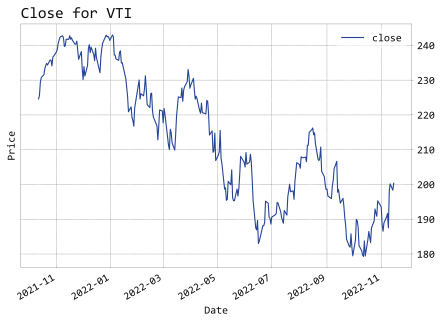

In [8]:
local_fig, ax = plt.subplots(dpi=20)
column = "close"
ticker_data.plot(x="date", y=column, ax=ax)
ax.set_title(f"{column.title()} for {ticker}")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
local_fig.tight_layout()
f = io.BytesIO()
local_fig.savefig(f, format="svg")
plot_chart = f.getvalue().decode("utf-8")

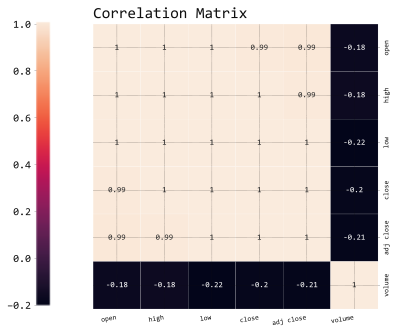

In [9]:
corr_chart = get_image(openbb.forecast.corr_chart, None, ticker_data)

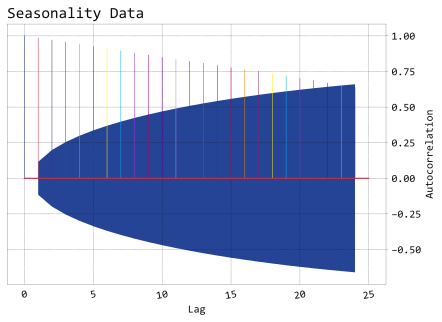

In [11]:
season_chart = get_image(openbb.forecast.season_chart, "Seasonality Data", ticker_data)

  0%|          | 0/40 [00:00<?, ?it/s]

Exponential smoothing obtains MAPE: 3.24%

   Actual price: 200.36    
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Datetime   ┃ Prediction ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ 2022-11-16 │ 200.76     │
├────────────┼────────────┤
│ 2022-11-17 │ 199.85     │
├────────────┼────────────┤
│ 2022-11-18 │ 200.72     │
├────────────┼────────────┤
│ 2022-11-21 │ 200.98     │
├────────────┼────────────┤
│ 2022-11-22 │ 200.85     │
└────────────┴────────────┘

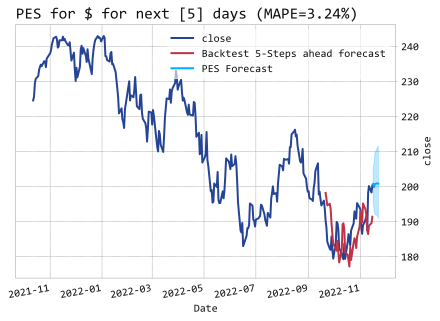

In [12]:
expo_chart = get_image(openbb.forecast.expo_chart, None, ticker_data)

In [ ]:
rnn_chart = get_image(openbb.forecast.rnn_chart, None, ticker_data)

## Render the report template to a file

In [ ]:
body = ""

img = (
    str(REPOSITORY_DIRECTORY)
    + "/openbb_terminal/reports/templates/OpenBB_reports_logo.png"
)
floppy_disk_img = (
    str(REPOSITORY_DIRECTORY) + "/openbb_terminal/reports/templates/floppy-disc.png"
)
body += widgets.header(
    img,
    floppy_disk_img,
    author,
    report_date,
    report_time,
    report_timezone,
    f"<b>FORECAST REPORT ON:</b> {ticker.upper()}",
)

body += widgets.tablinks(["SUMMARY"])

htmlcode = widgets.h(3, "Summary")
htmlcode += widgets.row([widgets.h(3, "Understand the data")])
htmlcode += widgets.row([ticker_data.head(10).to_html(), plot_chart])
htmlcode += widgets.row([widgets.h(3, "Analyzing the data")])
htmlcode += widgets.row([corr_chart, season_chart])
htmlcode += widgets.row([widgets.h(3, "Creating predictions")])
htmlcode += widgets.row([expo_chart, rnn_chart])

body += widgets.add_tab("SUMMARY", htmlcode)
body += widgets.tab_clickable_and_save_evt()
report = widgets.html_report(title=report_name, stylesheet=stylesheet, body=body)

# to save the results
with open(report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)